In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

import scipy
import scipy.stats as st
import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

import math
import tqdm

# The Metropolis-Hastings Algorithm

## Objectives

+ Use the Metropolis-Hastings algorithm (the most general Markov Chain Monte Carlo (MCMC) algorithm) to sample from an arbitrary probability density known up to a normalization constant.
+ Build new algorithms with Metropolis-Hastings. Example: Metrpolis Adjusted Langevin Dynamics.
+ Combining transition kernels using (approximate) Gibbs sampling to sample from complicated joint distributions.
+ Use MCMC to calibrate the reaction kinetics problem using the Bayesian formulation.

## Readings

+ Chapter 11 of Bishop.
+ These notes.

## Metropolis Adjusted Langevin Dynamics (MALA)

Here is a basic implementation of the MALA algorithm we introduced in the lecture.

In [2]:
def mala(x0, log_h, n, dt, args=()):
    """
    Random walk metropolis.
    
    :param x0:     The initial point (numpy array).
    :param log_h:  The logartihm of the function that is proportional to the density you want to sample from (function).
                   Returns also the gradient.
    :param n:      The maximum number of steps you want to take.
    :param dt:     The time step you want to use.
    :param args:   Any parameters to log_h
    
    :returns:  X, acceptance_rate
    """
    x0 = np.array(x0)
    assert x0.ndim == 1
    # Dimensionality of space
    d = x0.shape[0]
    # A place to store the samples
    X = np.ndarray((n + 1, d))
    X[0, :] = x0
    # Previous value of log(h(x))
    log_h_p, grad_log_h_p = log_h(x0, *args)

    # Keep track of how many samples are accepted
    count_accepted = 0
    # Start the simulation
    for t in tqdm.tqdm(range(1, n + 1)):
        # Generation
        x = X[t - 1, :] + dt * grad_log_h_p + np.sqrt(2. * dt) * np.random.randn(d)
        # Calculation
        log_h_c, grad_log_h_c = log_h(x, *args) # Current value of log(h(x))
        log_alpha_1 = log_h_c - log_h_p
        log_T_p_to_c = -np.sum((x - X[t - 1, :] - dt * grad_log_h_p) ** 2 / (4. * dt))
        log_T_c_to_p = -np.sum((x + dt * grad_log_h_c - X[t - 1, :]) ** 2 / (4. * dt))
        log_alpha_2 = log_T_c_to_p - log_T_p_to_c
        log_alpha = log_alpha_1 + log_alpha_2
        alpha = min(1, np.exp(log_alpha))
        # Accept/Reject
        u = np.random.rand()
        if u <= alpha: # Accept
            X[t, :] = x
            log_h_p = log_h_c
            grad_log_h_p = grad_log_h_c
            count_accepted += 1
        else:          # Reject
            X[t, :] = X[t - 1, :]
    # Empirical acceptance rate
    acceptance_rate = count_accepted / (1. * n)
    return X, acceptance_rate

## Example 1: Sampling from a Gaussian with MALA

Let's take $\mathcal{X}=\mathbb{R}^2$ and:

$$
\pi(x) \propto h(x) = \exp\left\{-\frac{1}{2}\left(x-\mu\right)^T\Lambda(x-\mu)\right\},
$$

where $\mu\in\mathbb{R}^2$ is the mean and $\Lambda = \Sigma^{-1}\in\mathbb{R}^{2\times 2}$ is the precision matrix.
We need:

$$
\log h(x) = -\frac{1}{2}(x-\mu)^T\Lambda (x-\mu),
$$

and

$$
\nabla \log h(x) = -\Lambda (x-\mu).
$$

In [3]:
def log_h_mvn(x, mu, Lambda):
    tmp = x - mu
    return -0.5 * np.dot(tmp, np.dot(Lambda, tmp)), -np.dot(Lambda, x - mu)

# The parameters of the disribution from which we wish to sample
mu = np.array([5., 2.])
Sigma = np.array([[1., .4],
                  [.3, 0.2]]) # This has to be positive definite - otherwise you will get garbage!
Lambda = np.linalg.inv(Sigma)

# Initialiazation:
x0 = np.random.randn(2)
# Parameters of the proposal:
dt = 0.15
# Number of steps:
n = 10000

# Start sampling
X, acceptance_rate = mala(x0, log_h_mvn, n, dt, args=(mu, Lambda))

print('Acceptance rate: %1.2f' % acceptance_rate)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 60722.77it/s]

Acceptance rate: 0.46


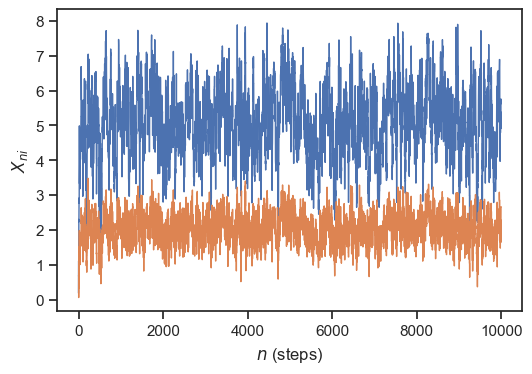

In [4]:
fig, ax = plt.subplots()
ax.plot(range(n + 1), X, lw=1)
ax.set_xlabel('$n$ (steps)')
ax.set_ylabel('$X_{ni}$');

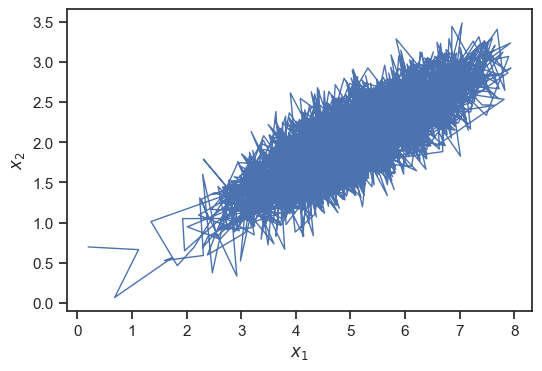

In [5]:
fig, ax = plt.subplots()
ax.plot(X[:, 0], X[:, 1], lw=1)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$');

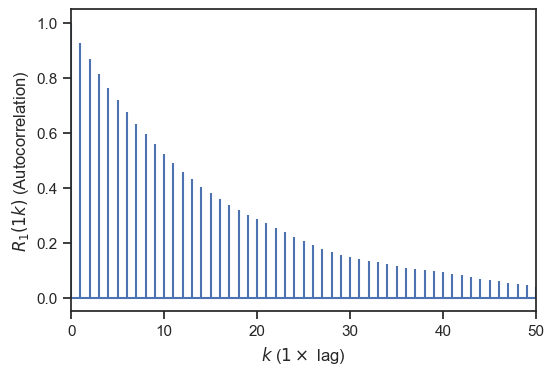

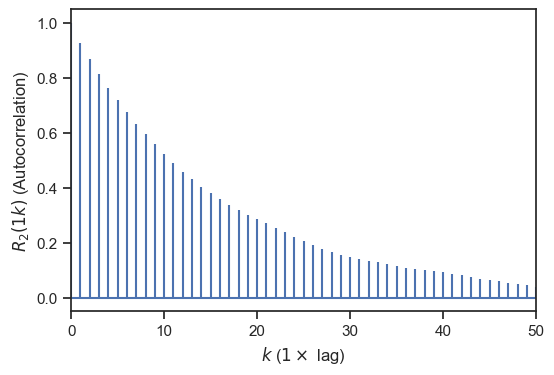

In [6]:
# How many samples do you want to burn?
burn = 500
# How many samples do you want to throw in between?
thin = 1 # Keep one every thin samples 
# Here are the remaining samples:
X_rest = X[burn::thin]
for i in range(X_rest.shape[1]):
    fig, ax = plt.subplots()
    ax.acorr(X_rest[:, 0], detrend=plt.mlab.detrend_mean, maxlags=50)
    ax.set_xlim(0, 50)
    ax.set_ylabel('$R_{%d}(%d k)$ (Autocorrelation)' % (i + 1, thin))
    ax.set_xlabel(r'$k$ ($%d \times$ lag)' % thin);

### Questions

- Play with the `thin` parameter until you get a satisfactory autocorrelation plot.